In [1]:
import torch
import random
import numpy as np
import os
from torch import nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

corpus_file = '../hw2.1_corpus.txt'

In [2]:
# Load Corpus

corpus = []
with open(corpus_file,'r') as f:
    for row in f:
        row = row.replace('\n','')
        row = [w for w in row]
        corpus.append(row)

In [3]:
# Use list to guarantee the embedded index for each word are same everytime

words = []
words_set = set()
for ws in corpus:
    for w in ws:
        if w not in words_set:
            words_set.add(w)
            words.append(w)

In [4]:
import re

class Embedding:

    def __init__(self,words=None,dim=300):
        self.word_dict = {}
        self.word_list = []
        self.emb_dim = dim
        self.maxPOS = 12      # Maximum POS
        self.addition_words = ['<PAD>','<SOS>','<EOS>','<UNK>']
        
        for POS in range(self.maxPOS):
            self.addition_words.append(str(POS))
        
        for addition_word in self.addition_words:
            if addition_word not in words:
                self.word_dict[addition_word] = len(self.word_list)
                self.word_list.append(addition_word)
        
        for word in words:
            if word not in self.word_dict:
                self.word_dict[word] = len(self.word_list)
                self.word_list.append(word)
                
        self.vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict),dim))
        
    def to_index(self, word):
        # single word tokenize
        if word not in self.word_dict:
            return self.word_dict['<UNK>']
        
        return self.word_dict[word]
        
    def tokenize(self, words):
        # whole sentence tokenize
        return [self.to_index(w) for w in words]
    
    def to_word(self, idx):
        
        return self.word_list[idx]
        
    def unTokenize(self,ids):
        
        return [self.to_word(idx) for idx in ids]
        
    def get_vocabulary_size(self):
        return self.vectors.shape[0]
    
    def get_dim(self):
        return self.vectors.shape[1]

In [5]:
# establish embedder to tokenize
embedder = Embedding(words=words,dim=300)

PAD = embedder.to_index('<PAD>')
SOS = embedder.to_index('<SOS>')
EOS = embedder.to_index('<EOS>')

In [6]:
all_set = []
counting_table = np.zeros((embedder.maxPOS+1,embedder.maxPOS+1))

for former,latter in zip(corpus[:-1],corpus[1:]):
    
    n = len(latter)
    
    addition_tokens = []
    
    former = ['<SOS>'] + former + ['<EOS>'] 
    latter = ['<SOS>'] + latter + ['<EOS>']
    
    selected_idx = random.randint(a=1,b=min(n,embedder.maxPOS))
    
    while 1:
        a = random.randint(a=0,b=selected_idx)
        b = selected_idx - a
        
        if (a,b) not in [(4,2),(2,4)]:
            break
        
    counting_table[a,b] += 1
    
    addition_tokens.append(latter[selected_idx])
    if a > 0:    
        addition_tokens.append(str(a))
    if b > 0:
        addition_tokens.append(str(b))
    
    former = former + addition_tokens
    
    all_set.append((former,latter))
    
print(counting_table)

[[    0. 53245. 33965. 23993. 18532. 13618. 14166.  7386.  4967.  3424.
   2287.  1386.   938.]
 [52850. 34177. 24569. 18287. 13703. 14547.  7361.  4983.  3395.  2432.
   1372.   990.     0.]
 [33861. 24124. 17963. 13659.     0.  7468.  5119.  3354.  2222.  1422.
    948.     0.     0.]
 [24103. 17906. 13833. 14281.  7182.  5033.  3345.  2265.  1460.   921.
      0.     0.     0.]
 [18318. 13950.     0.  7326.  5050.  3336.  2156.  1379.   895.     0.
      0.     0.     0.]
 [13669. 14122.  7446.  5015.  3413.  2302.  1439.   930.     0.     0.
      0.     0.     0.]
 [14368.  7346.  5173.  3444.  2244.  1387.   926.     0.     0.     0.
      0.     0.     0.]
 [ 7423.  5017.  3375.  2197.  1397.   934.     0.     0.     0.     0.
      0.     0.     0.]
 [ 4970.  3337.  2263.  1419.   957.     0.     0.     0.     0.     0.
      0.     0.     0.]
 [ 3323.  2197.  1453.   902.     0.     0.     0.     0.     0.     0.
      0.     0.     0.]
 [ 2292.  1419.   923.     0.     0.    

In [7]:
from sklearn.model_selection import train_test_split

train_set,valid_set = train_test_split(all_set,test_size=0.2,random_state=42)

print(len(all_set),len(train_set),len(valid_set))

741714 593371 148343


In [8]:
class SentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_data_len = max([len(data[0]) for data in datas])
        max_label_len = max([len(data[1]) for data in datas])
        
        batch_x = []
        batch_y = []
        len_x = []
        len_y = []
        batch_y_ = []
        
        
        for data,label in datas:
            
            len_x.append(len(data))
            len_y.append(len(label))
            
            # Tokenize
            pad_data = embedder.tokenize(data)
            pad_label = embedder.tokenize(label)
            
            # Padding data and label
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            if len(label) < max_label_len:
                pad_label.extend([PAD] * (max_label_len-len(label)))
                
                
            batch_x.append(pad_data)
            batch_y.append(pad_label)
            
            # generate y_
            focus_designate = [PAD] * len(pad_label)
            focus_designate[0] = SOS
            focus_designate[pad_label.index(EOS)] = EOS
            
            
            idx1 = data[data.index('<EOS>')+2]
            
            
            if data.index('<EOS>')+3 < len(data):
                idx2 = data[data.index('<EOS>')+3]
                idx = int(idx1) + int(idx2)
            else:
                idx = int(idx1)
            focus_designate[idx] = pad_label[idx]
            
            batch_y_.append(focus_designate)
            
            
        return torch.LongTensor(batch_x), torch.LongTensor(len_x), torch.LongTensor(batch_y), len_y, torch.LongTensor(batch_y_)

In [9]:
# For Validate~~~~

dataset = SentDataset(train_set)
dataloader = DataLoader(dataset=dataset,
                        batch_size=4,
                        shuffle=True,
                        collate_fn=dataset.collate_fn,
                        num_workers=0)
for x,x_len,y,y_len,y_ in dataloader:
    print('Sentence lenght:',x_len,y_len,'\n')
    
    for xi,yi,y_i in zip(x,y,y_):      
        
        print(embedder.unTokenize(xi))
        print(embedder.unTokenize(yi))
        print(embedder.unTokenize(y_i),'\n')
    
    break


Sentence lenght: tensor([13, 12,  9, 11]) [15, 12, 7, 9] 

['<SOS>', '只', '是', '想', '起', '你', '就', '会', '孤', '单', '<EOS>', '碗', '5']
['<SOS>', '回', '忆', '像', '一', '碗', '热', '汤', '想', '念', '那', '么', '滚', '烫', '<EOS>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '碗', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>'] 

['<SOS>', '要', '达', '到', '一', '番', '兴', '奋', '<EOS>', '界', '1', '2', '<PAD>']
['<SOS>', '全', '世', '界', '替', '我', '开', '心', '先', '兴', '奋', '<EOS>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '界', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>', '<PAD>', '<PAD>', '<PAD>'] 

['<SOS>', '谁', '解', '凭', '栏', '意', '<EOS>', '楚', '3', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '既', '然', '楚', '天', '阔', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '<PAD>', '楚', '<PAD>', '<PAD>', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

[

In [10]:
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size):
        
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedder.get_dim())
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.gru = nn.GRU(embedding_size, output_size,batch_first=True, bias=False)

    def forward(self, input_seqs, input_lengths, hidden=None):
        
        # Sort mini-batch by input_lengths
        sorted_input_lengths, indices = torch.sort(input_lengths,descending=True)
        _, desorted_indices = torch.sort(indices, descending=False)
        input_seqs = input_seqs[indices]
        
        # Encoder work
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, sorted_input_lengths.cpu().numpy(), batch_first=True)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs,batch_first=True)
        
        # Desort mini-batch
        outputs = outputs[desorted_indices]
        hidden = hidden[:,desorted_indices]
        
        return outputs, hidden

In [11]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, teacher_forcing_ratio=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim()) # Unused
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.cell = nn.GRUCell(embedder.get_dim(), hidden_size, bias=False)
        self.clf = nn.Linear(hidden_size, output_size, bias=False)
        
        if hidden_size == embedder.vectors.T.shape[0]:
            self.clf.weight = nn.Parameter(embedder.vectors)

        self.log_softmax = nn.LogSoftmax(dim=1)  # work with NLLLoss

        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward_step(self, inputs, hidden):
        
        # Unused
        embedded = self.embedding(inputs)
        # For research : all x to 0
        embedded = torch.zeros_like(embedded)
        
        hidden = self.cell(embedded, hidden) # [B,Hidden_dim]
        clf_output = self.clf(hidden) # [B,Output_dim]
        output = self.log_softmax(clf_output)

        return output, hidden

    def forward(self, context_vector, target_vars, target_lengths):

        batch_size = context_vector.shape[1]
        
        decoder_input = torch.LongTensor([SOS] * batch_size).to(device)
        decoder_hidden = context_vector.squeeze(0)

        if target_lengths is None:
            max_target_length = 50
        else:
            max_target_length = max(target_lengths)
        decoder_outputs = []
        decoder_hiddens = []

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        for t in range(max_target_length):    
            
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_outputs_on_t)
            decoder_hiddens.append(decoder_hidden)
            
            # Take input for next GRU iteration
            if use_teacher_forcing :
                decoder_input = target_vars[:,t]
            else:
                decoder_input = decoder_outputs_on_t.argmax(-1)
            
            # Early Stop when all predict <EOS> 
            if torch.all(decoder_input==EOS) and target_lengths is None and self.train() == False:
                break
            
        # Stack output of each word at dimension 2
        decoder_outputs = torch.stack(decoder_outputs,dim=2)
        # Stack hidden of each timestep at dimension 1
        decoder_hiddens = torch.stack(decoder_hiddens,dim=1)
        
        return decoder_outputs, decoder_hiddens

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input_seqs, input_lengths, target_seqs=None, target_lengths=None):
        outputs, hidden = encoder(input_seqs, input_lengths)
        outputs, hiddens = decoder(hidden, target_seqs, target_lengths)
        return outputs,hiddens

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

context_dim = 128

encoder = Encoder(embedder.get_vocabulary_size(),embedder.get_dim(),output_size=context_dim)
decoder = Decoder(context_dim,embedder.get_vocabulary_size(),0.5)
model = Seq2Seq(encoder,decoder)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6575, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6575, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6575, bias=False)
    (log_softmax): LogSoftmax()
  )
)

# Training

In [14]:
'''def run_epoch(epoch,dataset,isTraining):
    
    if isTraining:
        model.train()
    else:
        model.eval()
        
    dataloader = DataLoader(dataset=dataset,
                            batch_size=32,
                            shuffle=True,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)
    
    if isTraining:
        desc='Train {}'
    else:
        desc='Valid {}'
    
    trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))
    
    loss=0
    acc = 0
    
    for i,(x,x_len,y,y_len,y_) in trange:
        
        x = x.to(device)
        y = y.to(device)
        y_ = y_.to(device)
        
        # outputs : [b,emb,s] , hiddens : [b,s,hidden]
        outputs,hiddens = model(x,x_len,y,y_len)
        
        idx = y_>2
        tf_map = y_[idx] == outputs.argmax(1)[idx]
        batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)
        acc += batch_acc
        
        batch_loss_all = criterion(outputs, y)
        batch_loss_designated = criterion(outputs, y_)
        batch_loss = (1-focus_ratio)*batch_loss_all + focus_ratio*batch_loss_designated
        
        if isTraining:
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        loss += batch_loss.item()
        
        trange.set_postfix({'loss':loss/(i+1),'accuracy':acc/(i+1)})
        
        if isTraining:
            history_loss['train'].append(batch_loss.item())
            history_acc['train'].append(batch_acc)
        else:
            history_loss['valid'].append(batch_loss.item())
            history_acc['valid'].append(batch_acc)'''

"def run_epoch(epoch,dataset,isTraining):\n    \n    if isTraining:\n        model.train()\n    else:\n        model.eval()\n        \n    dataloader = DataLoader(dataset=dataset,\n                            batch_size=32,\n                            shuffle=True,\n                            collate_fn=dataset.collate_fn,\n                            num_workers=0)\n    \n    if isTraining:\n        desc='Train {}'\n    else:\n        desc='Valid {}'\n    \n    trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))\n    \n    loss=0\n    acc = 0\n    \n    for i,(x,x_len,y,y_len,y_) in trange:\n        \n        x = x.to(device)\n        y = y.to(device)\n        y_ = y_.to(device)\n        \n        # outputs : [b,emb,s] , hiddens : [b,s,hidden]\n        outputs,hiddens = model(x,x_len,y,y_len)\n        \n        idx = y_>2\n        tf_map = y_[idx] == outputs.argmax(1)[idx]\n        batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)\n        ac

In [15]:
'''# Training


dataset_all = SentDataset(all_set)
dataset_train = SentDataset(train_set)
dataset_valid = SentDataset(valid_set)

criterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
max_epoch = 20
focus_ratio = 0.5

history_loss = {'train':[],'valid':[]}
history_acc = {'train':[],'valid':[]}


for epoch in range(max_epoch):
    
    # Training
    run_epoch(epoch,dataset=dataset_train,isTraining=True)
    
    # Validation
    run_epoch(epoch,dataset=dataset_valid,isTraining=False)
    
    # Saving
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))'''

"# Training\n\n\ndataset_all = SentDataset(all_set)\ndataset_train = SentDataset(train_set)\ndataset_valid = SentDataset(valid_set)\n\ncriterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\nmax_epoch = 20\nfocus_ratio = 0.5\n\nhistory_loss = {'train':[],'valid':[]}\nhistory_acc = {'train':[],'valid':[]}\n\n\nfor epoch in range(max_epoch):\n    \n    # Training\n    run_epoch(epoch,dataset=dataset_train,isTraining=True)\n    \n    # Validation\n    run_epoch(epoch,dataset=dataset_valid,isTraining=False)\n    \n    # Saving\n    if not os.path.exists('model'):\n        os.makedirs('model')\n    torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))"

# Plot (Loss and acc)

In [16]:
'''import matplotlib.pyplot as plt

modes = ['train', 'valid']
recs = [history_loss, history_acc]
names = ['Loss', 'Accuracy']

values = []
for mode in modes:
    v = []
    for rec in recs:
        v.append(rec[mode])
    values.append(v)
 
plt.figure(figsize=(32, 4))
plt.subplots_adjust(left=0.02, right=0.999)
for r, name in enumerate(names):
    plt.subplot(1, len(recs), r+1)
    for m in range(len(modes)):
        plt.plot(values[m][r])
    plt.title(name)
    plt.legend(modes)
    plt.xlabel('iteration')
    plt.show()
#plt.savefig('figure.png', dpi=100)'''

"import matplotlib.pyplot as plt\n\nmodes = ['train', 'valid']\nrecs = [history_loss, history_acc]\nnames = ['Loss', 'Accuracy']\n\nvalues = []\nfor mode in modes:\n    v = []\n    for rec in recs:\n        v.append(rec[mode])\n    values.append(v)\n \nplt.figure(figsize=(32, 4))\nplt.subplots_adjust(left=0.02, right=0.999)\nfor r, name in enumerate(names):\n    plt.subplot(1, len(recs), r+1)\n    for m in range(len(modes)):\n        plt.plot(values[m][r])\n    plt.title(name)\n    plt.legend(modes)\n    plt.xlabel('iteration')\n    plt.show()\n#plt.savefig('figure.png', dpi=100)"

# Inference Test Data
### Define test data dataloader

In [17]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        max_data_len = max([len(data) for data in datas])
        batch_x = []
        len_x = []
        
        for data in datas:
            len_x.append(len(data))
            pad_data = [embedder.to_index(w) for w in data]
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            batch_x.append(pad_data)

        return torch.LongTensor(batch_x), torch.LongTensor(len_x)

## Load pre-trained model

In [18]:
path_pkl = '../pre-train/model.pkl.2-2-additional_without42&24'
model.load_state_dict(torch.load(path_pkl))
model.decoder.teacher_forcing_ratio = 0.0
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6575, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6575, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6575, bias=False)
    (log_softmax): LogSoftmax()
  )
)

## 做一個指定位置的context hidden

In [19]:
context_spos = ['<SOS>', '让', '我', '拥', '有', '了', '恬', '静', '的', '<EOS>', '静','3','2']
len_context = torch.LongTensor([len(context_spos)])
context_spos = [embedder.to_index(w) for w in context_spos]
context_spos = torch.LongTensor([context_spos]).to(device)
context_spos = model.encoder(context_spos,len_context)[1] 
context_spos = context_spos.squeeze()# context hidden

In [20]:
context_spos.shape

torch.Size([128])

# Weight of Encoder

## https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/rnn.py
\begin{array}{ll}
    r_t = \sigma(W_{ir} x_t + W_{hr} h_{(t-1)}) \\
    z_t = \sigma(W_{iz} x_t + W_{hz} h_{(t-1)}) \\
    n_t = \tanh(W_{in} x_t + r_t * (W_{hn} h_{(t-1)})) \\
    h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
\end{array}

Attributes:

weight_ih_l[k] :

the learnable input-hidden weights of the $\text{k}^{th}$ layer (W_ir|W_iz|W_in), of shape `(3*hidden_size, input_size)` for `k = 0`.

Otherwise, the shape is `(3*hidden_size, num_directions * hidden_size)`

weight_hh_l[k] :

the learnable hidden-hidden weights of the $\text{k}^{th}$ layer (W_hr|W_hz|W_hn), of shape `(3*hidden_size, hidden_size)`

In [21]:
def plot_weights(W,
    groups=None,
    perm_dim=(True, True),
    figsize=(32,28),
    xlabels_override=[],
    ylabels_override=[],
    activation=''):
    
    ######### dirty code
    if activation=='':
        pass
    elif activation=='sig':
        W = 1 / (1 + np.exp(-W))
    elif activation=='tanh':
        W = np.tanh(W)
    else:
        print(f'Unknown activation function: {activation}')
        return
    #########
    
    # concatenate groups and reorder cells
    if groups:
        indices = []
        seps = [] # separations
        ticks, labels = [], []
        accu = 0
        for g, group in enumerate(groups):
            indices += group
            accu += len(group)
            seps.append(accu)
            ticks.append(accu-len(group)/2)
            labels.append(f'{g}: {len(group)}')
        seps = seps[:-1]
        if perm_dim[0]:
            W = W[indices,:]
        if perm_dim[1]:
            W = W[:,indices]
        
    # plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ######### dirty code
    if activation=='':
        vmax = np.max(np.abs(W))
        vmin = -vmax
    elif activation=='sig':
        vmax = 1.0
        vmin = 0.0
    elif activation=='tanh':
        vmax = 1.0
        vmin = -1.0
    plt.imshow(W, cmap='bwr', vmax=vmax, vmin=vmin)
    #########
    plt.colorbar().ax.tick_params(labelsize=48)
    
    # add separation lines
    if groups:
        for sep in seps:
            if perm_dim[0]:
                plt.axhline(y=sep-0.5, color='black', linewidth=1.0)
            if perm_dim[1]:
                plt.axvline(x=sep-0.5, color='black', linewidth=1.0)
        plt.xticks(fontsize=48)
        plt.yticks(fontsize=48)
        if perm_dim[0]:
            plt.yticks(ticks, labels)
            plt.ylabel('Group ID: Group size', fontsize=48)
            
    ######### dirty code
    if xlabels_override:
        plt.xticks(range(len(xlabels_override)), xlabels_override)
    if ylabels_override:
        plt.yticks(range(len(ylabels_override)), ylabels_override)
    #########
    
    plt.savefig('weight_.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

In [22]:
def plot_ht(ht_1, ht, addend, animation=False):
    n_subplot = 3 # should divide n_num
    n_num = ht.shape[0]//n_samp
    h = np.zeros([ht.shape[0]*2, ht.shape[1]])
    for i in range(n_num):
        h[(i*2)*n_samp:(i*2+1)*n_samp] = ht_1[i*n_samp:(i+1)*n_samp]
        h[(i*2+1)*n_samp:(i*2+2)*n_samp] = ht[i*n_samp:(i+1)*n_samp]
    
    if animation==False:
        fig = plt.figure(figsize=(32,16))
    for s in range(n_subplot):
        ax = plt.subplot(1, n_subplot, s+1, )

        bgn = n_num//n_subplot*s
        end = min(bgn+n_num//n_subplot, n_num)
        W = h[bgn*n_samp*2:end*n_samp*2, pos_cells]
        
        # plot
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        im = plt.imshow(W, cmap='bwr', vmax=1, vmin=-1)

        # add separation lines
        for sep in range(n_samp, n_num//n_subplot*n_samp*2, n_samp*2):
            plt.axhline(y=sep-0.5, color='black', linewidth=1.0)
        for sep in range(n_samp*2, n_num//n_subplot*n_samp*2, n_samp*2):
            plt.axhline(y=sep-0.5, color='black', linewidth=2.0)

        if s==0:
            yticks = [bgn*n_samp*2-0.5]
            for i in range(bgn,end):
                yticks += [i*n_samp*2+n_samp*0.5-0.5]
                yticks += [i*n_samp*2+n_samp*1.5-0.5]
            yticks += [end*n_samp*2-0.5]

        ylabels = ['']
        for i in range(bgn,end):
            ylabels += [str(i+1)]
            ylabels += [f'{str(i+1)}+{addend}']
        ylabels += ['']

        plt.xticks(range(len(pos_cells)), pos_cells, fontsize=12)
        plt.yticks(yticks, ylabels, fontsize=24)

    if animation==False:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=20)
        
    #     plt.savefig('weight_.png', dpi=100, bbox_inches='tight', pad_inches=0)
        plt.show()
    if animation==True:
        return im

In [23]:
pos_emb = [*range(4,16)]+[3]
embedder.word_list[:20]

['<PAD>',
 '<SOS>',
 '<EOS>',
 '<UNK>',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '心',
 '疼',
 '你',
 '还']

In [24]:
w_emb = model.encoder.embedding.weight.cpu().detach().numpy()
w_emb.shape

(6575, 300)

In [25]:
w_enc_ih = model.encoder.gru.weight_ih_l0.cpu().detach().numpy()
print(f'w_enc_ih: {w_enc_ih.shape}')
w_enc_ir, w_enc_iz, w_enc_in = w_enc_ih[0:128, :], w_enc_ih[128:256, :], w_enc_ih[256:384, :]
print(f'w_enc_ir, w_enc_iz, w_enc_in: {w_enc_ir.shape}')

w_enc_hh = model.encoder.gru.weight_hh_l0.cpu().detach().numpy()
print(f'w_enc_hh: {w_enc_hh.shape}')
w_enc_hr, w_enc_hz, w_enc_hn = w_enc_hh[0:128, :], w_enc_hh[128:256, :], w_enc_hh[256:384, :]
print(f'w_enc_hr, w_enc_hz, w_enc_hn: {w_enc_hr.shape}')

w_enc_ih: (384, 300)
w_enc_ir, w_enc_iz, w_enc_in: (128, 300)
w_enc_hh: (384, 128)
w_enc_hr, w_enc_hz, w_enc_hn: (128, 128)


In [26]:
pos_cells = [13,47,111,12,36,31,43,62,95,104,60,49,29,59,51,79,50,63]

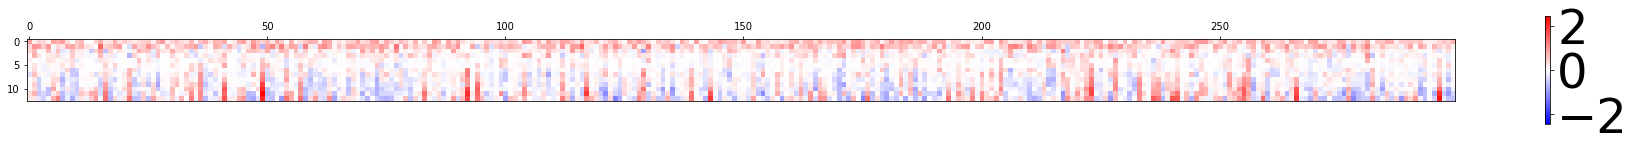

In [27]:
plot_weights(w_emb[pos_emb, :], figsize=(32,2))

average of squared distances of samples to centers: 0.8269525015915311
average of squared distances of centers to centers: 4.455117416381836
ratio: 5.3873921510699025


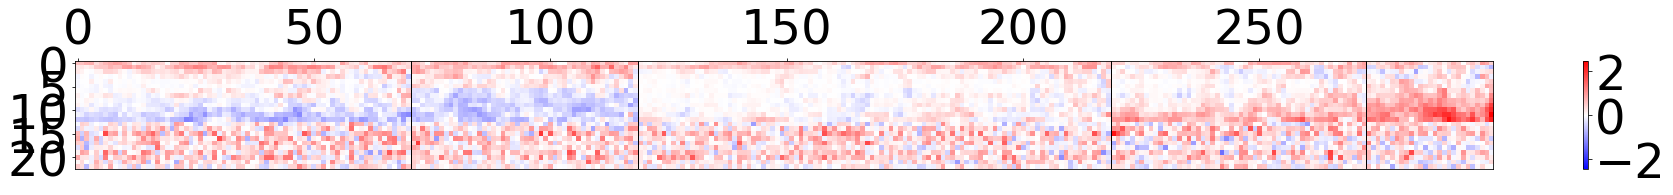

In [28]:
import Cell
groups, centers = Cell.cluster(w_emb[pos_emb, :].transpose(), 5)
plot_weights(w_emb[pos_emb+[*range(20,30)], :], groups, perm_dim=(0,1), figsize=(32,2))

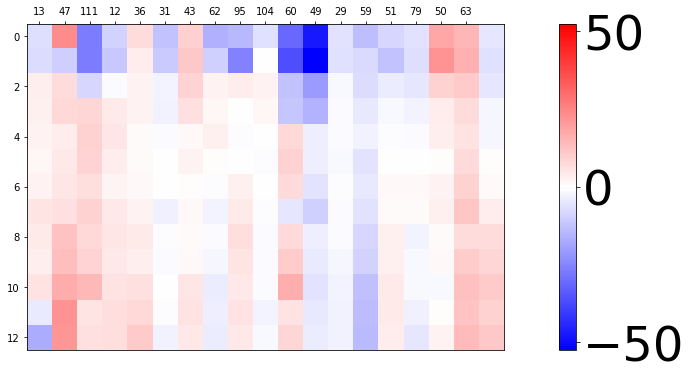

In [29]:
plot_weights(
    w_emb[pos_emb, :] @ w_enc_in.transpose()[:, pos_cells+[18]],
    figsize=(20,6),
    xlabels_override=pos_cells,
    activation='')

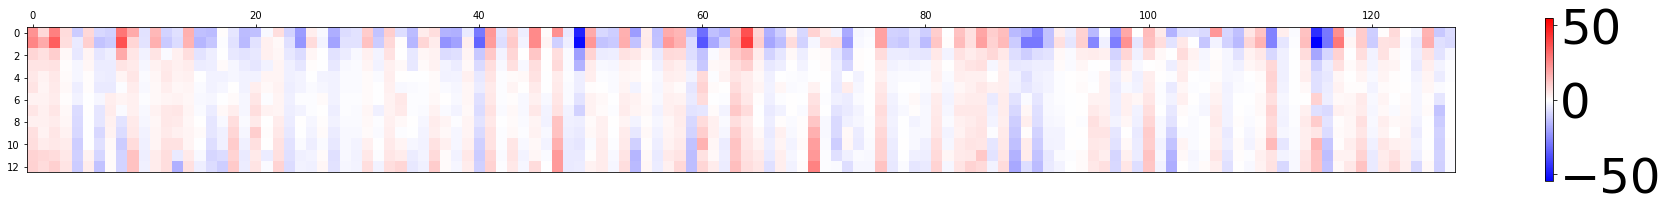

In [30]:
plot_weights(w_emb[pos_emb, :] @ w_enc_in.transpose(), figsize=(32,3))

# Deconstruct

In [31]:
class Info:
    def __init__(self):
        self.__dict__ = dict()

In [32]:
import torch.nn.functional as F

def Deconstruction(model,x,x_len):
    
    # Encoder 
    encoder_hiddens, context = model.encoder(x,x_len)
    context = context.squeeze(0)
    
    ht_1 = encoder_hiddens[:,-2,:]
    xt_1 = model.encoder.embedding(x[:,-1])
    U_h = F.linear(ht_1,encoder.gru.weight_hh_l0)
    W_x = F.linear(xt_1, encoder.gru.weight_ih_l0)
    Ur_h, Uz_h, Un_h = U_h.chunk(3, 1)
    Wr_x, Wz_x, Wn_x = W_x.chunk(3, 1)
    reset_gate_en = torch.sigmoid(Wr_x + Ur_h)
    update_gate_en = torch.sigmoid(Wz_x+Uz_h)
    new_gate_en = torch.tanh( Wn_x +reset_gate_en * Un_h)
    ht = new_gate_en + update_gate_en * (ht_1 - new_gate_en)
    
    enc_info = Info()
    enc_info.__dict__={
        'ht_1': ht_1.cpu().detach().numpy(),
        'U_h': U_h.cpu().detach().numpy(),
        'W_x': W_x.cpu().detach().numpy(),
        'reset': reset_gate_en.cpu().detach().numpy(),
        'update': update_gate_en.cpu().detach().numpy(),
        'new': new_gate_en.cpu().detach().numpy(),
        'ht': ht.cpu().detach().numpy(),
    }
    
    # Switch the context hidden
    cells = []
    for c in cells:
        context[:,c] = context_spos[c]
    
    # Decoder
    decoder_hidden = context.squeeze(0)
    
    # Collection signal
    decoder_outputs = []
    decoder_hiddens = []
    decoder_resetGates = []
    decoder_updateGates = []
    decoder_newGates = []
    
    while True:
        
        # GRU Cell
        gru = model.decoder.cell
        
        U_h = F.linear(decoder_hidden, gru.weight_hh)
        Ur_h, Uz_h, Un_h = U_h.chunk(3, 1)
        reset_gate = torch.sigmoid(Ur_h)
        update_gate = torch.sigmoid(Uz_h)
        new_gate = torch.tanh(reset_gate * Un_h)
        decoder_hidden = new_gate + update_gate * (decoder_hidden - new_gate)
        
        # Classifier
        clf_output = model.decoder.clf(decoder_hidden)
        decoder_output = model.decoder.log_softmax(clf_output)
        
        decoder_resetGates.append(reset_gate)
        decoder_updateGates.append(update_gate)
        decoder_newGates.append(new_gate)
        decoder_outputs.append(decoder_output)            
        decoder_hiddens.append(decoder_hidden)
                                                   
        if torch.all(decoder_output.argmax(-1)==EOS) == True:
            break
            
    outputs = torch.stack(decoder_outputs,dim=2)             # (b,6xxx,s)
    
    gru_info = { 
        'context':context,                                        # (b,128)
        'hiddens':torch.stack(decoder_hiddens,dim=2),             # (b,128,s)
        'resetgates':torch.stack(decoder_resetGates,dim=2),       # (b,128,s)
        'updategates':torch.stack(decoder_updateGates,dim=2),     # (b,128,s)
        'newgates':torch.stack(decoder_newGates,dim=2)            # (b,128,s)
    }
    
    return outputs, gru_info, enc_info

## Generate certain condition valid datas ( by designated word / position filter )

In [33]:
certain_set = []

for sent in random.sample(corpus, k=2):
    
    if len(sent) > 8:
        sent = sent[:8]
    else:
        sent = sent + ['啊']*(8-len(sent))
    
    designated_POS = random.randint(a=2,b=10)
    designated_POS1 = random.randint(a=1,b=designated_POS-1)
    designated_POS2 = designated_POS - designated_POS1
    
    designated_word = random.choice(random.choice(corpus))
    
    control_signal = [ designated_word, str(designated_POS1) , str(designated_POS2)]
    
    control_signal = [ designated_word, '4','2']
    
    data = ['<SOS>'] + sent + ['<EOS>'] + control_signal
    
    print(data)
    
    certain_set.append(data)
    
dataset_certain = TestDataset(certain_set)

['<SOS>', '耳', '聋', '难', '与', '人', '说', '话', '啊', '<EOS>', '手', '4', '2']
['<SOS>', '我', '们', '都', '那', '么', '坚', '强', '啊', '<EOS>', '记', '4', '2']


In [34]:
n_samp = 4
def get_certain_set(addend):
    certain_set = []

    for i in range(1, 13):
        for sent in random.sample(corpus, k=n_samp):

            if len(sent) > 8:
                sent = sent[:8]
            else:
                sent = sent + ['啊']*(8-len(sent))

            designated_word = random.choice(random.choice(corpus))
            control_signal = [designated_word, str(i), str(addend)]
            data = ['<SOS>'] + sent + ['<EOS>'] + control_signal
#             print(data)
            certain_set.append(data)

    return TestDataset(certain_set)

In [35]:
def get_enc_info(addend):
    dataset_certain = get_certain_set(addend)
    dataloader = DataLoader(dataset=dataset_certain,
                        batch_size=128,
                        shuffle=False,
                        collate_fn=dataset_certain.collate_fn,
                        num_workers=0)

    predictions = []
    trange = tqdm(dataloader, total=len(dataloader))

    for x,x_len in trange:

        x = x.to(device)

        outputs,gru_info, enc_info = Deconstruction(model,x,x_len)

        for pred in outputs.cpu().detach().numpy().argmax(1):
            predictions.append(pred)
    return enc_info

## Prediction certain condition data

In [36]:
dataloader = DataLoader(dataset=dataset_certain,
                        batch_size=128,
                        shuffle=False,
                        collate_fn=dataset_certain.collate_fn,
                        num_workers=0)

predictions = []
trange = tqdm(dataloader, total=len(dataloader))

for x,x_len in trange:
    
    x = x.to(device)
    
    outputs,gru_info, enc_info = Deconstruction(model,x,x_len)
    
    for pred in outputs.cpu().detach().numpy().argmax(1):
        predictions.append(pred)

In [37]:
try:
    ht_1 = enc_info.ht_1
    Ur_h, Uz_h, Un_h = np.split(enc_info.U_h, 3, axis=1)
    Wr_x, Wz_x, Wn_x = np.split(enc_info.W_x, 3, axis=1)
    enc_reset = enc_info.reset
    enc_update = enc_info.update
    enc_new = enc_info.new
    ht = enc_info.ht
    print('OK')
except:
    pass

OK


In [38]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

/home/mvnl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/home/mvnl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


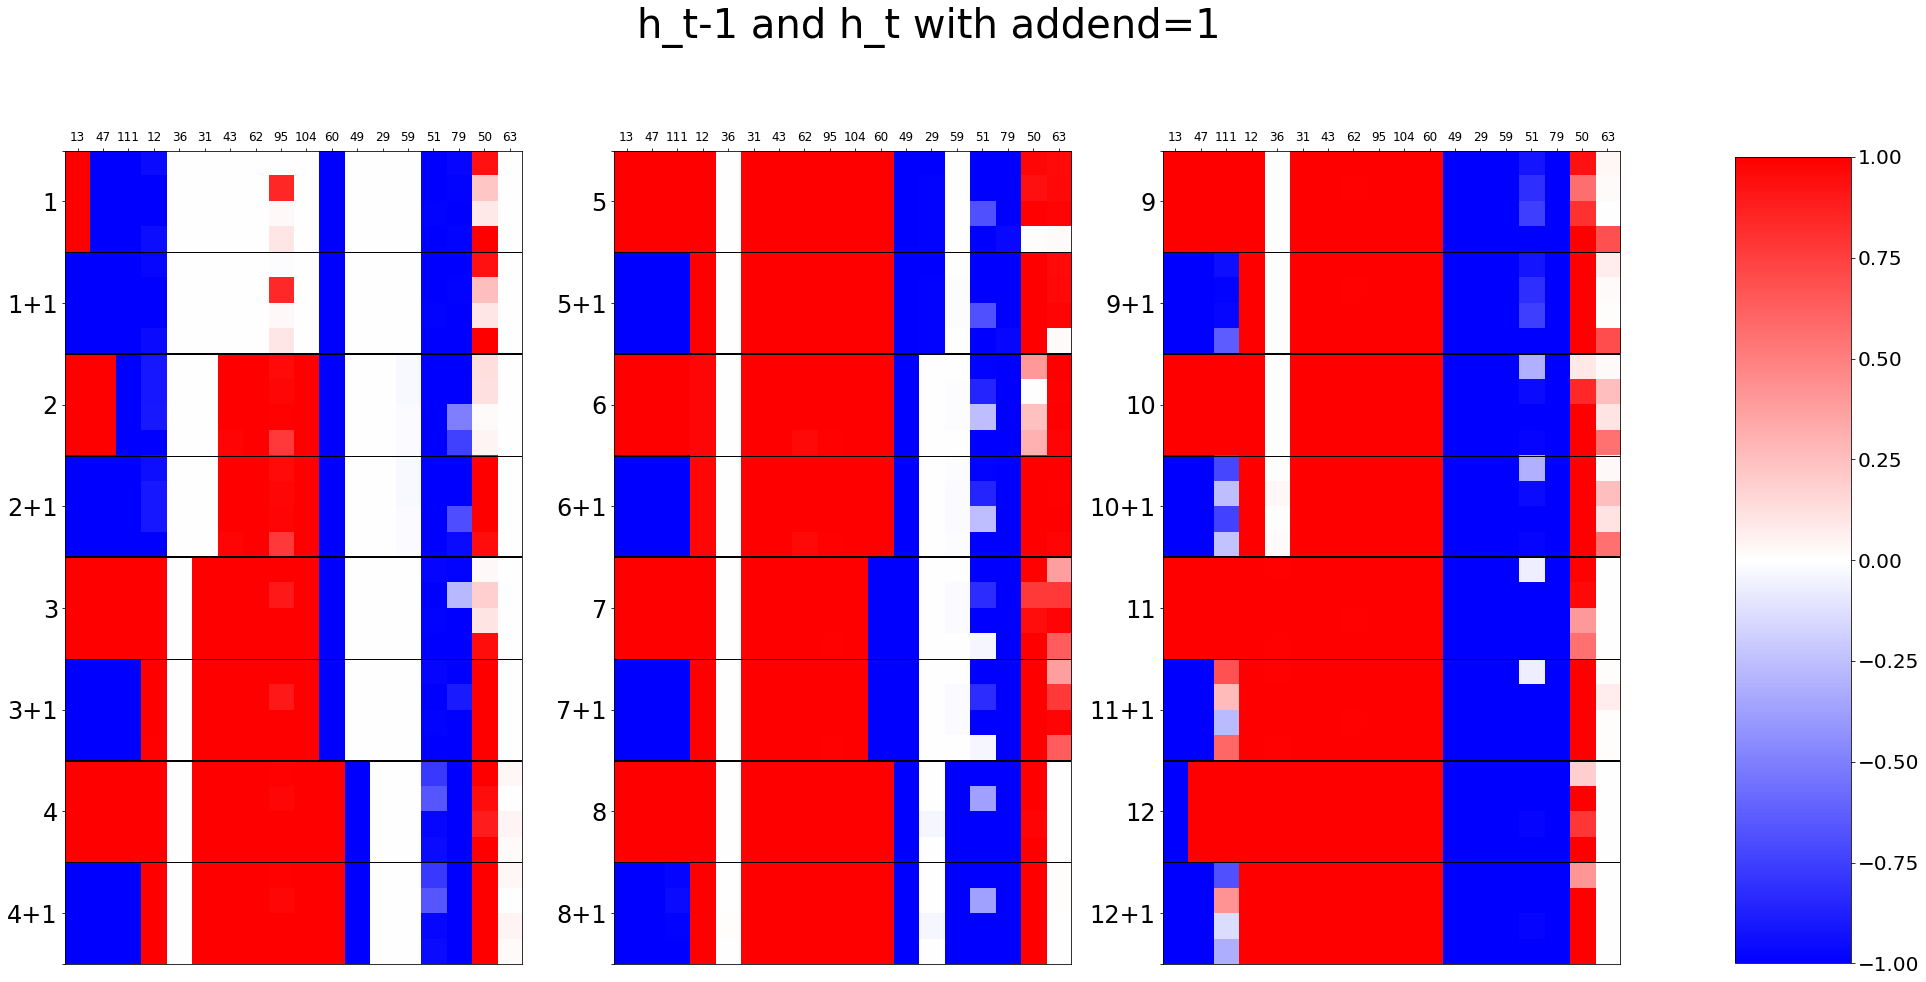

In [39]:
def func(addend, fig):
    plt.cla()
    enc_info = get_enc_info(addend)
    ht_1 = enc_info.ht_1
    ht = enc_info.ht
    im = plot_ht(ht_1, ht, addend, animation=True)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=20)
    fig.suptitle(f'h_t-1 and h_t with addend={addend}', fontsize=40)
fig = plt.figure(figsize=(32,16))
anim = FuncAnimation(fig, func=func, frames=range(1,9), fargs=(fig, ), interval=200)
HTML(anim.to_jshtml())
# anim.save('ht_1 and ht.gif', writer='imagemagick', fps=6)

In [40]:
# Process multi-EOS tokens
predictions_set = []
for p in predictions:
    p = list(p)
    if EOS in p:
        p = p[:p.index(EOS)+1]
    else:
        p.append(EOS)
    predictions_set.append(embedder.unTokenize(p))
    

for sent_id in range(len(certain_set)):
    sent_in = ''.join(certain_set[sent_id])
    sent_pred = ''.join(predictions_set[sent_id])
    print('input:\t{}\npred:\t{}\n'.format(sent_in,sent_pred))

input:	<SOS>耳聋难与人说话啊<EOS>手42
pred:	<SOS>我要你你的手<EOS>

input:	<SOS>我们都那么坚强啊<EOS>记42
pred:	<SOS>我不你你忘记<EOS>



In [41]:
updategates = gru_info['updategates'].mean(0).detach().cpu().numpy()

resetgates = gru_info['resetgates'].mean(0).detach().cpu().numpy()

newgates = gru_info['newgates'].mean(0).detach().cpu().numpy()

context = gru_info['context'].detach().cpu().numpy()

output_len = updategates.shape[1]

updategates.shape , resetgates.shape , newgates.shape , context.shape


((128, 8), (128, 8), (128, 8), (2, 128))

In [42]:
context_set = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

for xi,hi in zip(x,context):
    xi = xi.cpu().numpy()
    pos = 0
    for token in xi[::-1]:
        w = embedder.to_word(token)
        if w.isdigit():
            pos += int(w)
        else:
            break
    print(pos,w)
    context_set[pos].append(hi)
    
for i in range(1,len(context_set)):
    try:
        context_set[i] = np.stack(context_set[i],axis=0)
    except:
        print('pos',i,'is empty')
        pass

6 手
6 记
pos 1 is empty
pos 2 is empty
pos 3 is empty
pos 4 is empty
pos 5 is empty
pos 7 is empty
pos 8 is empty
pos 9 is empty
pos 10 is empty
pos 11 is empty
pos 12 is empty
